In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data Preparation and Manipulation

In [2]:
def shorten_date(date_string):
    ''' Shorten date string to only have up to day information
    Args:
        date_string (str): raw date string from tweets
    
    Returns:
        date_string[:10] : just the date string up to the days
    '''
    return date_string[:10]

In [3]:
def clean_csv(filename):
    ''' Load and clean the stock tweets csv file and load into a dataframe
    Args:
        filename (str): name of the csv file
    
    Returns:
        df (pd.DataFrame): dataframe of stock tweets
    '''
    # load file and delete unnecessary columns
    df = pd.read_csv(filename).drop(columns=['Unnamed: 0'])
    df = df.drop_duplicates(subset=['tweet'], keep='first')
    
    # sort chronologically
    df = df.sort_values(by=['date']).reset_index()
    df = df.drop(columns=['index'])
    
    # convert date into shorter format
    df['date'] = df['date'].map(shorten_date)
    
    return df

In [4]:
# load dataframes of the four stocks
aapl_df = clean_csv('AAPL_verified.csv')
amzn_df = clean_csv('AMZN_verified.csv')
jpm_df = clean_csv('JPM_verified.csv')
xom_df = clean_csv('XOM_verified.csv')

In [5]:
def str_to_dt(date_string):
    ''' convert date string into datetime format
    Args:
        date_string (str): date in string format
        
    Returns:
        dt (datetime): datetime formatted date
    '''
    dt = datetime.strptime(date_string[:10], '%Y-%m-%d').date()
    
    return dt

In [6]:
def abstract_pol(abstract):
    ''' find the news abstract polarity score
    Args:
        abstract (str): the abstract of the given news article
    
    Returns:
        pol (float): polarity sentiment score of the abstract
    '''
    pol, sub = TextBlob(str(abstract)).sentiment
    
    return pol

In [7]:
def abstract_sub(abstract):
    ''' find the news abstract subjectivity score
    Args:
        abstract (str): the abstract of the given news article
    
    Returns:
        sub (float): subjectivity sentiment score of the abstract
    '''
    pol, sub = TextBlob(str(abstract)).sentiment
    
    return sub

In [8]:
def merge_df(stock_df, tweet_df, ticker):
    ''' Returns the sentiment score for tweets given the stock and date
    Args:
        stock_df (pd.DataFrame): dataframe with daily return and prices data
        tweet_df (pd.DataFrame): dataframe with stock tweets data
        ticker (str): stock ticker sybmol 
        
    Returns:
        tweet_score_return (pd.DataFrame): dataframe with stock return and sentiment 
                                            scroes for given day and stock 
    '''
    # load tweet scores
    tweet_df['date'] = tweet_df['date'].map(str_to_dt)
    tweet_df['twt_ver_pol'] = tweet_df['tweet'].map(abstract_pol)
    tweet_df['twt_ver_sub'] = tweet_df['tweet'].map(abstract_sub)
    
    # find the average polarity and subjectivity scores for each day
    tweet_pol = tweet_df.groupby('date')['twt_ver_pol'].mean()
    tweet_sub = tweet_df.groupby('date')['twt_ver_sub'].mean()
    
    # create new datframe of just the scores
    tweet_score_df = pd.DataFrame(tweet_pol)
    tweet_score_df = tweet_score_df.merge(tweet_sub, on='date')
    tweet_score_df['Stock ticker'] = [ticker] * len(tweet_score_df)
    
    # merge with stock data
    tweet_score_return = pd.merge(left=stock_df, right=tweet_score_df, how ='left', on=['date', 'Stock ticker'])
    
    # filter to only have ticker data
    tweet_score_return = tweet_score_return[tweet_score_return['Stock ticker']==ticker].dropna().reset_index().drop(columns=['index'])
    
    return tweet_score_return

In [9]:
# Load stock data
stock_df = pd.read_csv('All Stock.csv')
stock_df = stock_df[stock_df['Data'] > '2019-01-01']

# calculate arithmetic return
stock_df = stock_df.rename(columns={'Data':'date'})
stock_df['daily return'] = (stock_df['Close'] - stock_df['Open']) / stock_df['Open'] 
stock_df[stock_df['date'] > '2019-01-01']
stock_df['date'] = stock_df['date'].map(str_to_dt)

In [10]:
# load scores dataframe for each ticker
aapl_score_df = merge_df(stock_df, aapl_df, 'AAPL')
amzn_score_df = merge_df(stock_df, amzn_df, 'AMZN')
jpm_score_df = merge_df(stock_df, jpm_df, 'JPM')
xom_score_df = merge_df(stock_df, xom_df, 'XOM')

# combine the dataframe
final_df = pd.concat([aapl_score_df, amzn_score_df, jpm_score_df, xom_score_df])
final_df

,date,Open,Close,Adj Close,Company,Industry,Stock ticker,daily return,twt_ver_pol,twt_ver_sub
0,2019-01-02,38.722500,39.480000,38.505024,Apple,Technology,AAPL,0.019562,0.067945,0.337475
1,2019-01-03,35.994999,35.547501,34.669640,Apple,Technology,AAPL,-0.012432,0.062963,0.352197
2,2019-01-04,36.132500,37.064999,36.149662,Apple,Technology,AAPL,0.025808,0.054305,0.336207
3,2019-01-07,37.174999,36.982498,36.069202,Apple,Technology,AAPL,-0.005178,0.111271,0.289180
4,2019-01-08,37.389999,37.687500,36.756794,Apple,Technology,AAPL,0.007957,0.120292,0.354182
...,...,...,...,...,...,...,...,...,...,...
124,2019-12-17,69.980003,69.680000,63.449207,Exxon,Energy,XOM,-0.004287,0.347222,0.686111
125,2019-12-20,69.860001,69.940002,63.685963,Exxon,Energy,XOM,0.001145,0.000000,0.000000
126,2019-12-23,69.860001,70.290001,64.004662,Exxon,Energy,XOM,0.006155,0.216667,0.277778
127,2019-12-24,70.349998,70.019997,63.758801,Exxon,Energy,XOM,-0.004691,-0.450000,0.700000


## Data Visualization

#### Scatter Plot of Return vs Polarity Score

<AxesSubplot:xlabel='twt_ver_pol', ylabel='daily return'>

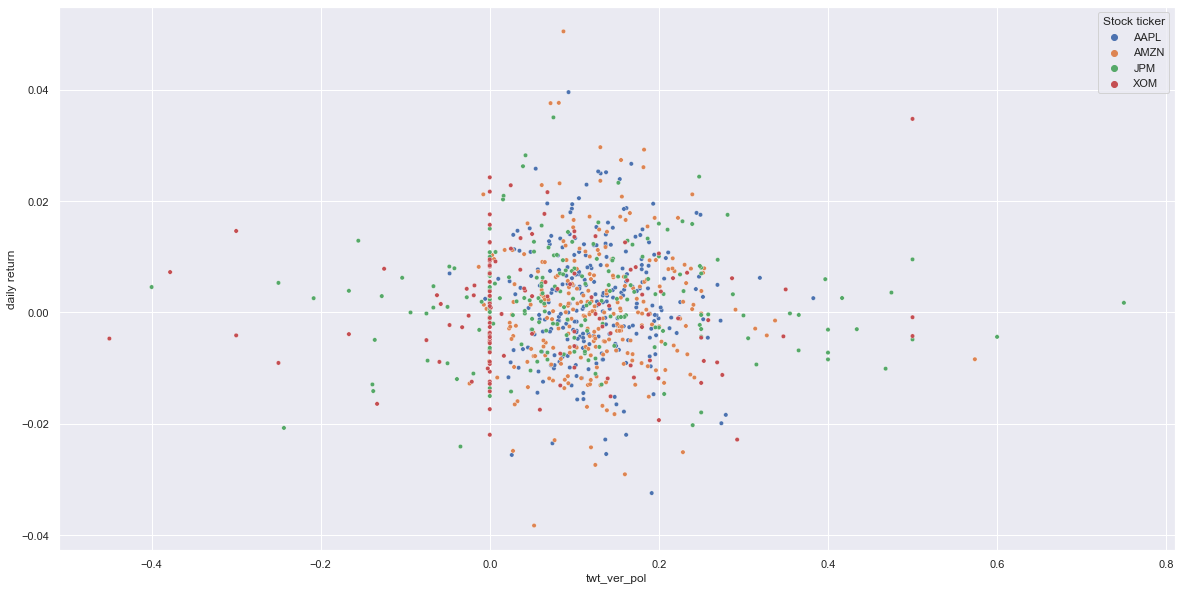

In [11]:
# general Scatter Plot of all returns and scores
plt.figure(figsize=(20,10))
sns.scatterplot(x=final_df['twt_ver_pol'], y=final_df['daily return'], hue=final_df['Stock ticker'], s=20)

#### Line Plot of Return and Polarity Score over time

In [12]:
def week(date):
    ''' function that returns the day of the week
    Args:
        date (datetime): given date in datetime
    
    Returns:
        date.weekday(): the day of the week indicated by 0 to 6
    '''
    return date.strftime("%V")

In [13]:
# group the final dataframe by date to find mean scores
date_grouped = final_df.groupby('date').mean().reset_index()

# find week number
date_grouped['week'] = date_grouped['date'].apply(week)

# group by week number 
date_grouped = date_grouped.groupby('week').mean().reset_index()
date_grouped.head()

,week,Open,Close,Adj Close,daily return,twt_ver_pol,twt_ver_sub
0,01,542.842914,550.296674,547.335707,0.015171,0.132105,0.335873
1,02,541.385001,543.395962,540.264848,0.002150,0.111750,0.315199
2,03,548.654207,551.191621,548.016061,0.006829,0.109417,0.378200
3,04,535.374424,530.740735,527.387472,-0.004595,0.131318,0.300322
4,05,513.483873,513.738376,509.758638,0.002609,0.066018,0.383576


In [14]:
# add normalized return and sentiment scores for comparison in movement
date_grouped['norm_return'] = (date_grouped['daily return'] - date_grouped['daily return'].mean())  / date_grouped['daily return'].std()
date_grouped['norm_pol'] = (date_grouped['twt_ver_pol'] - date_grouped['twt_ver_pol'].mean()) / date_grouped['twt_ver_pol'].std()
date_grouped['norm_sub'] = (date_grouped['twt_ver_sub'] - date_grouped['twt_ver_sub'].mean()) / date_grouped['twt_ver_sub'].std()
date_grouped.head()

,week,Open,Close,Adj Close,daily return,twt_ver_pol,twt_ver_sub,norm_return,norm_pol,norm_sub
0,01,542.842914,550.296674,547.335707,0.015171,0.132105,0.335873,3.761192,0.919195,0.148925
1,02,541.385001,543.395962,540.264848,0.002150,0.111750,0.315199,0.258835,0.001074,-0.398522
2,03,548.654207,551.191621,548.016061,0.006829,0.109417,0.378200,1.517249,-0.104161,1.269712
3,04,535.374424,530.740735,527.387472,-0.004595,0.131318,0.300322,-1.555436,0.883705,-0.792474
4,05,513.483873,513.738376,509.758638,0.002609,0.066018,0.383576,0.382284,-2.061744,1.412069


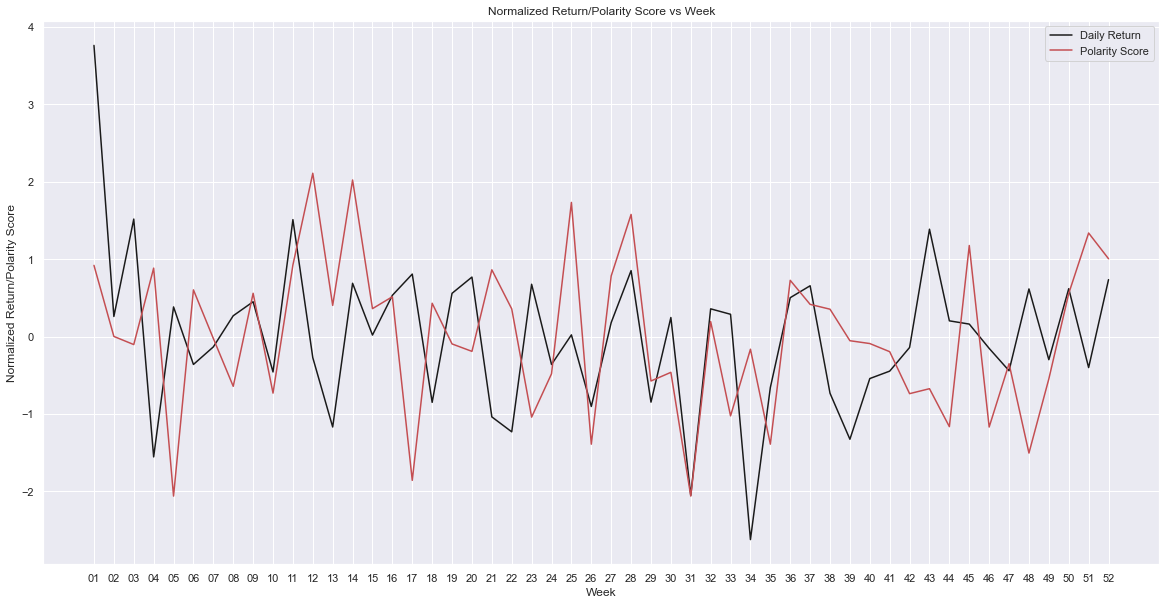

In [15]:
# Plot the entire 2019's trend
plt.figure(figsize=(20,10))
plt.plot(date_grouped['week'], date_grouped['norm_return'], color='k', label='Daily Return')
plt.plot(date_grouped['week'], date_grouped['norm_pol'], color='r', label='Polarity Score')

# Add labels
plt.title('Normalized Return/Polarity Score vs Week')
plt.xlabel('Week')
plt.ylabel('Normalized Return/Polarity Score')
plt.legend()

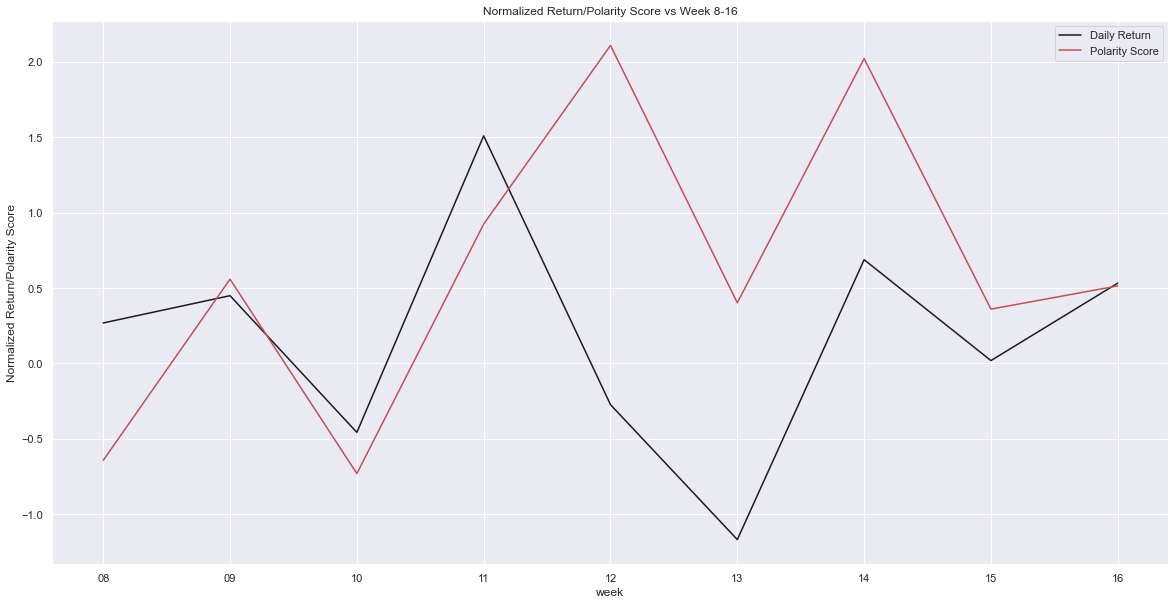

In [16]:
# Plot the weeks when the movements seem to be in sync
plt.figure(figsize=(20,10))
plt.plot(date_grouped['week'][7:16], date_grouped['norm_return'][7:16], color='k', label='Daily Return')
plt.plot(date_grouped['week'][7:16], date_grouped['norm_pol'][7:16], color='r', label='Polarity Score')

# Add labels
plt.title('Normalized Return/Polarity Score vs Week 8-16')
plt.xlabel('week')
plt.ylabel('Normalized Return/Polarity Score')
plt.legend()

## Data Analysis using Linear Regression

We wanted to see if the data from week 8 to week 16 would give us any significant results considering the movement of polarity scores and returns seem the most related. We used Linear Regression for this analysis and calculated the cross-validated r2 values.

In [17]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [18]:
# Add week number on full data
final_df['week'] = final_df['date'].apply(week)

# Add normalized returns and scores
final_df['norm_return'] = (final_df['daily return'] - final_df['daily return'].mean())  / final_df['daily return'].std()
final_df['norm_pol'] = (final_df['twt_ver_pol'] - final_df['twt_ver_pol'].mean()) / final_df['twt_ver_pol'].std()
final_df['norm_sub'] = (final_df['twt_ver_sub'] - final_df['twt_ver_sub'].mean()) / final_df['twt_ver_sub'].std()
final_df.head()

,date,Open,Close,Adj Close,Company,Industry,Stock ticker,daily return,twt_ver_pol,twt_ver_sub,week,norm_return,norm_pol,norm_sub
0,2019-01-02,38.722500,39.480000,38.505024,Apple,Technology,AAPL,0.019562,0.067945,0.337475,01,1.786527,-0.392095,0.043050
1,2019-01-03,35.994999,35.547501,34.669640,Apple,Technology,AAPL,-0.012432,0.062963,0.352197,01,-1.323703,-0.437969,0.143360
2,2019-01-04,36.132500,37.064999,36.149662,Apple,Technology,AAPL,0.025808,0.054305,0.336207,01,2.393661,-0.517682,0.034406
3,2019-01-07,37.174999,36.982498,36.069202,Apple,Technology,AAPL,-0.005178,0.111271,0.289180,02,-0.618532,0.006815,-0.286023
4,2019-01-08,37.389999,37.687500,36.756794,Apple,Technology,AAPL,0.007957,0.120292,0.354182,02,0.658334,0.089873,0.156888


In [19]:
# create a dataframe that consist of week 8 to week 16 data
sync_df = final_df.loc[(final_df['week']>'07') & (final_df['week']<'17'), :]

In [20]:
# target features
x_feat_list = ['norm_pol', 'norm_sub']
x = sync_df.loc[:, x_feat_list].values
y = sync_df.loc[:,'daily return'].values

# build linear regression model
reg = LinearRegression()

# fit regression
reg.fit(x, y)
y_pred = reg.predict(x) 

# print model
print('Linear Regression Model:')
print(f'intercept : {reg.intercept_}')
print(f'coefficients: {reg.coef_}')

Linear Regression Model:
intercept : 0.0010758530678316837
coefficients: [-0.00018394  0.00016617]


In [21]:
# initialize an empty array same size as y
y_pred = np.empty_like(y)

# split data indexes
n = 10
kf = KFold(n_splits=n)

# find 10 fold cross validated r2
for train_idx, test_idx in kf.split(x):

    # sort training and testing data
    x_train, y_train = x[train_idx,:], y[train_idx]
    x_test, y_test = x[test_idx,:], y[test_idx]

    # train model on training data
    reg = LinearRegression()
    reg.fit(x_train, y_train)

    # predict
    y_pred[test_idx] = reg.predict(x_test) 

r2 = r2_score(y_true=y, y_pred=y_pred)
print(f'{n}-fold cross-validated r2 : {r2:.5f}')   

10-fold cross-validated r2 : -0.03462
